In [237]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../data/data-cluster-examples-pause"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    # if "fallingDrop" not in directory:
    #     print(f"Skipping {directory}")
    #     continue

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        # assert len(corresponding_liveInfo) == len(
        #     tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # convert tuningData timings into percentages
        maxTime = tuningData["Reduced"].max()
        tuningData.insert(1, "PerformancePercentage", (
            tuningData["Reduced"] / maxTime) * 100)

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

        # describe data
        # print(f"Time: {time}")
        # print(corresponding_liveInfo["avgParticlesPerCell"].describe())
        # print("")

Processing ../../data/data-cluster-examples-pause/uniformCube_b_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_1
Processing ../../data/data-cluster-examples-pause/explodingLiquid_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_2
Processing ../../data/data-cluster-examples-pause/explodingLiquid_2
Processing ../../data/data-cluster-examples-pause/fallingDrop_2
Processing ../../data/data-cluster-examples-pause/uniformCube_b_1
Processing ../../data/data-cluster-examples-pause/fallingDrop_1


# Load Data from Folders


In [239]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(173989, 29)

In [240]:
df.describe()

avgParticlesPerCell         cutoff    domainSizeX    domainSizeY  \
count        173989.000000  173989.000000  173989.000000  173989.000000   
mean              1.037087       2.905787      72.816032      66.771253   
std               0.760317       0.263705      26.012171      15.016017   
min               0.070312       2.000000      15.000000      29.561231   
25%               0.905797       3.000000      50.000000      50.000000   
50%               0.905797       3.000000      93.750000      78.750000   
75%               0.944637       3.000000      93.750000      78.750000   
max               6.829864       3.000000     240.000000     240.000000   

         domainSizeZ  estimatedNumNeighborInteractions    homogeneity  \
count  173989.000000                      1.739890e+05  173989.000000   
mean       58.299270                      1.652280e+05       0.071020   
std        15.238906                      1.154401e+06       0.058028   
min        15.000000                      1.488300e+04       0.033138   
25%        50.000000                      8.255900e+04       0.036599   
50%        68.750000                      1.458290e+05       0.050815   
75%        68.750000                      1.547930e+05       0.082505   
max       240.000000                      4.966793e+07       0.430119   

          maxDensity  maxParticlesPerCell  minParticlesPerCell  ...  \
count  173989.000000        173989.000000        173989.000000  ...   
mean        0.501286            19.424820             0.000540  ...   
std         0.207742             5.522057             0.023237  ...   
min         0.095751             8.000000             0.000000  ...   
25%         0.358178            16.000000             0.000000  ...   
50%         0.485846            21.000000             0.000000  ...   
75%         0.627706            23.000000             0.000000  ...   
max         1.602795            44.000000             1.000000  ...   

       particleSizeNeededByFunctor  particlesPerBlurredCellStdDev  \
count                     173989.0                  173989.000000   
mean                          72.0                       0.242749   
std                            0.0                       0.264643   
min                           72.0                       0.016345   
25%                           72.0                       0.062254   
50%                           72.0                       0.201113   
75%                           72.0                       0.304941   
max                           72.0                       2.680734   

       particlesPerCellStdDev  rebuildFrequency           skin    threadCount  \
count           173989.000000          173989.0  173989.000000  173989.000000   
mean                 0.036430              10.0       0.918311      13.789998   
std                  0.061651               0.0       0.221811      10.666233   
min                  0.000594              10.0       0.200000       1.000000   
25%                  0.013075              10.0       1.000000       4.000000   
50%                  0.013912              10.0       1.000000      12.000000   
75%                  0.040112              10.0       1.000000      24.000000   
max                  0.617061              10.0       1.000000      28.000000   

       PerformancePercentage  CellSizeFactor       Reduced      Smoothed  
count          173988.000000        173989.0  1.739880e+05  1.739880e+05  
mean               37.263336             1.0  2.212340e+07  2.185305e+07  
std                15.126270             0.0  1.486986e+08  1.486906e+08  
min                 0.140350             1.0  9.449830e+05  9.449830e+05  
25%                26.759312             1.0  1.007140e+07  9.932487e+06  
50%                34.902070             1.0  1.668692e+07  1.637831e+07  
75%                46.813911             1.0  2.352305e+07  2.311560e+07  
max               100.000000             1.0  1.100861e+10  1.100861e+10  

[8 ro

In [241]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Define Interesting Data to observe


In [242]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    # "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [243]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Filter Data / Outliers


In [244]:
# only keep rows where performance percentage is above x
print("Orignal length", len(df))

dffiltered = df[df["PerformancePercentage"] >= 70]

print("Filtered top performance length", len(dffiltered))


def combine_columns(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# group data on input columns and concatenate output columns
dfgrouped = dffiltered.groupby(inputs).agg(combine_columns).reset_index()

print("Grouped length", len(dfgrouped))

# remove columns that are not needed
dfgrouped.drop(columns=["Reduced", "Smoothed",
               "PerformancePercentage"], inplace=True)


# filter values occuring less than pct
pct = 0.01
for column in outputs:
    counts = dfgrouped[column].value_counts()
    dfgrouped = dfgrouped[dfgrouped[column].isin(
        counts[counts > len(dfgrouped) * pct].index)]


print("Sparse values removed length", len(dfgrouped))

X, y = dfgrouped[inputs], dfgrouped[outputs]
print(X.shape, y.shape)

Orignal length 173989
Filtered top performance length 4919
Grouped length 1617
Sparse values removed length 1451
(1451, 5) (1451, 3)


# Create Train and Test Data


In [245]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [246]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  particlesPerCellStdDev  \
1420             0.944637     0.093976    0.476160                0.043793   
1168             0.944637     0.082778    0.621240                0.040521   
510              0.905797     0.048035    0.258881                0.014119   
1299             0.944637     0.083734    0.740280                0.040072   
142              0.905797     0.035544    0.535494                0.012762   

      threadCount                     Container_DataLayout  \
1420           28                   VerletClusterLists_AoS   
1168            1                   VerletClusterLists_AoS   
510            24  LinkedCells_AoS, VerletClusterLists_AoS   
1299           24                   VerletClusterLists_AoS   
142            28                   VerletClusterLists_AoS   

                                              Traversal  Newton 3  
1420   vcl_c01_balanced, vcl_c06, vcl_cluster_iteration  disabled  
1168            vcl_c01_balanced, vcl_cluster_iteration  disabled  
510   lc_c01, lc_sliced_balanced, vcl_c01_balanced, ...  disabled  
1299                          vcl_c01_balanced, vcl_c06  disabled  
142                                    vcl_c01_balanced  disabled

In [247]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

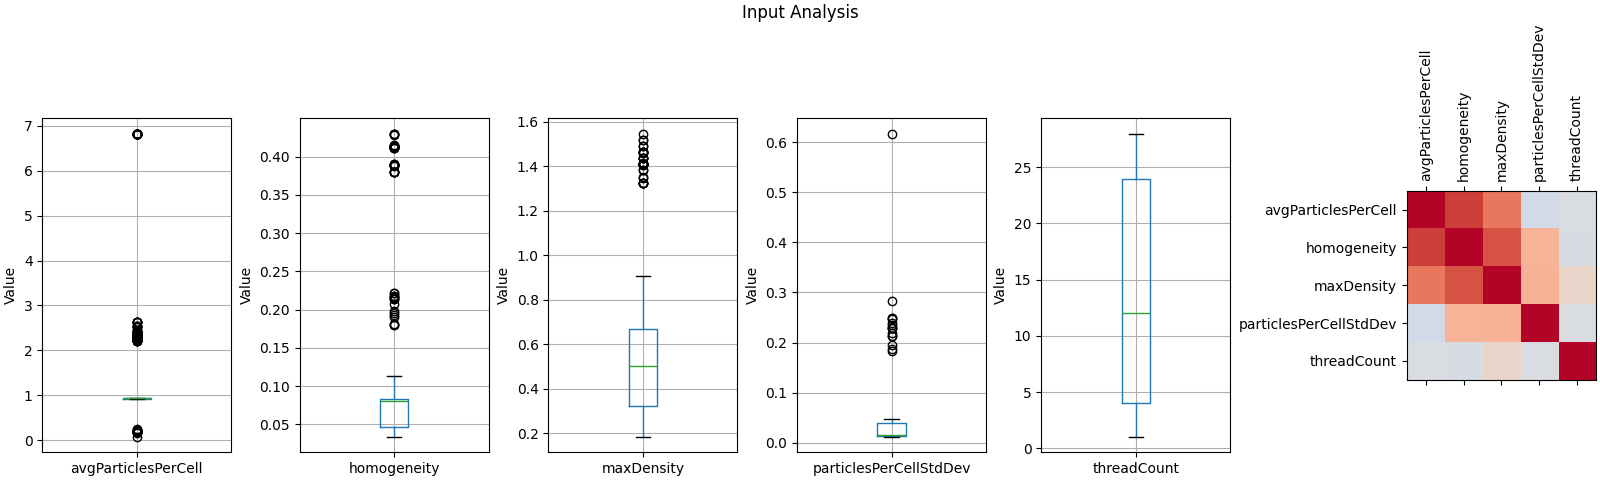

In [248]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [249]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.08,
    "Traversal": 0.1,
    "Newton 3": 0.02,

}

# maximum depth of the decision tree
MAX_DEPTH = 10

# how many models should be created for each label
TOP_K_MODELS_PER_LABEL = 2


Training on 1160 samples
Number of rules 44:
	Container_DataLayout (13 rules)
	Traversal (30 rules)
	Newton 3 (1 rules)


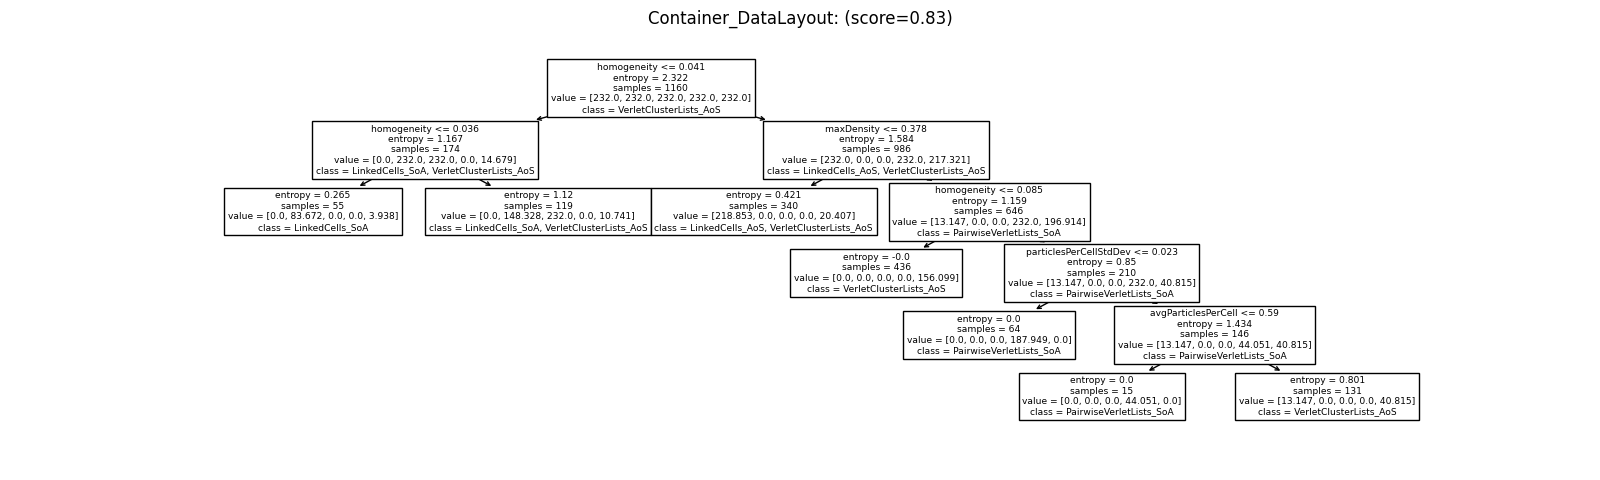

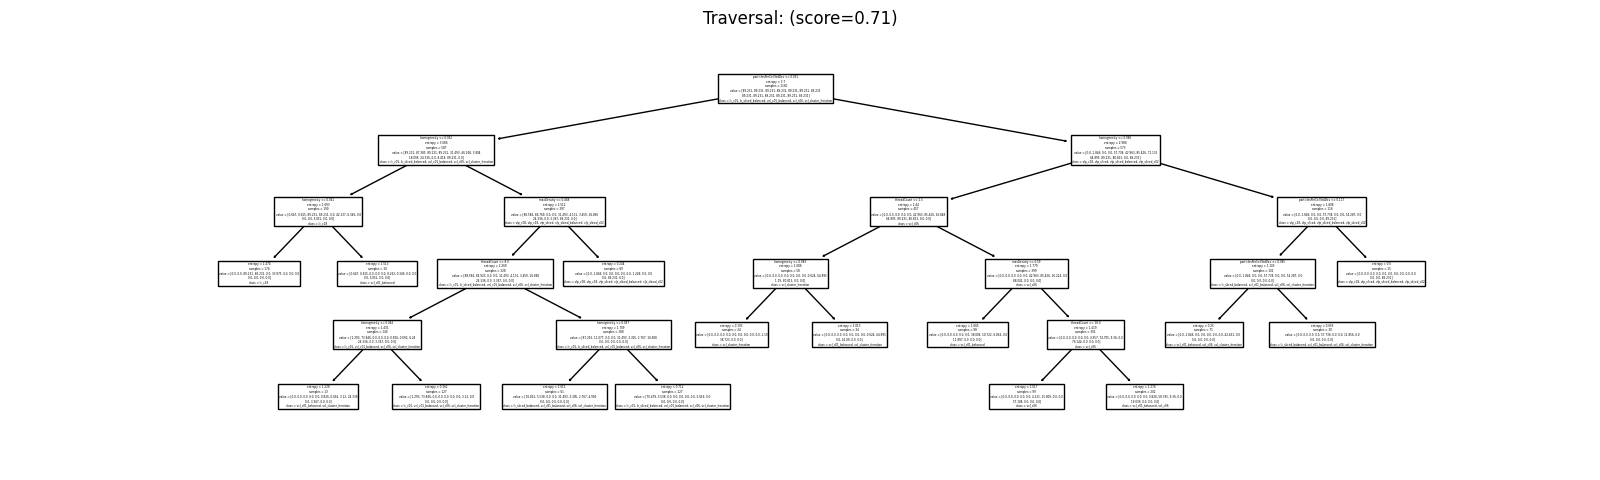

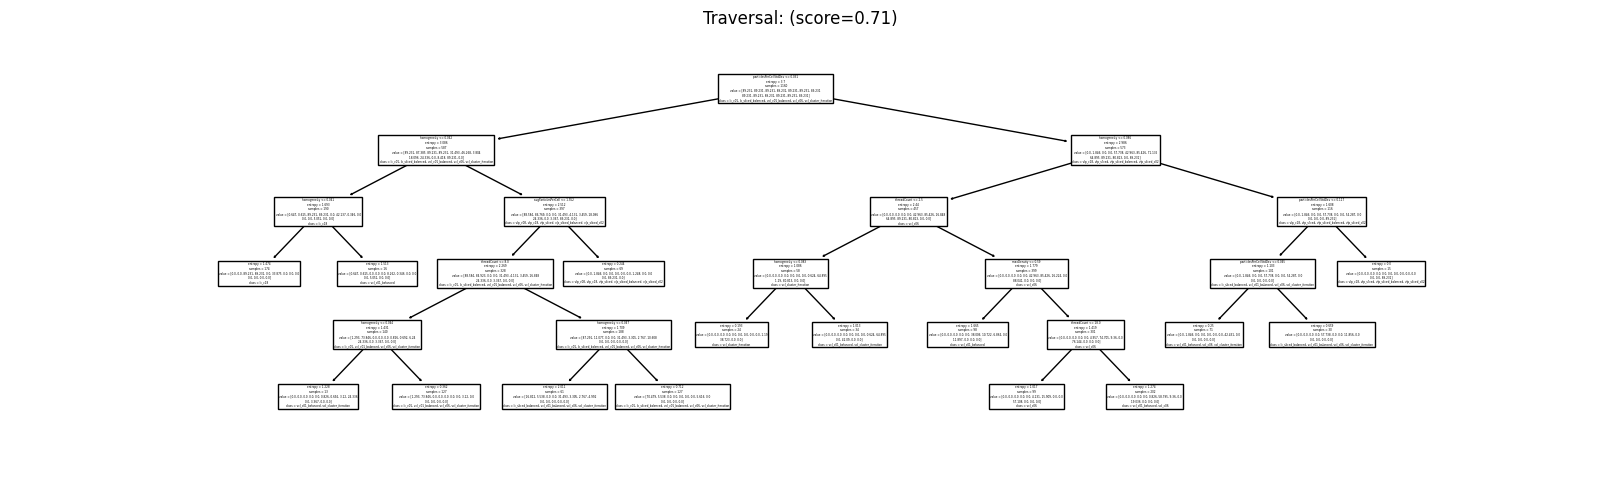

In [250]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

homogeneity: [-inf, 0.036, 0.041, 0.042, 0.044, 0.047, 0.066, 0.083, 0.085, 0.086, inf]
homogeneity: [-inf, 0.036, 0.041, 0.044, 0.047, 0.066, 0.083, 0.085, inf]

maxDensity: [-inf, 0.378, 0.468, 0.59, inf]
maxDensity: [-inf, 0.378, 0.468, 0.59, inf]

particlesPerCellStdDev: [-inf, 0.023, 0.031, 0.045, 0.117, inf]
particlesPerCellStdDev: [-inf, 0.023, 0.031, 0.045, 0.117, inf]

avgParticlesPerCell: [-inf, 0.59, 1.552, inf]
avgParticlesPerCell: [-inf, 0.59, 1.552, inf]

threadCount: [-inf, 2.5, 8.0, 18.0, inf]
threadCount: [-inf, 2.5, 8.0, 18.0, inf]



/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/../demo/fuzzy-test/python/fuzzy_system.py:409: RuntimeWarning: overflow encountered in exp
  def function(x): return 1 / (1 + np.exp(-width * (x - center)))


delta_x = 0.0007783760288419565, number of points = 7.708356601020483, should be at least 10


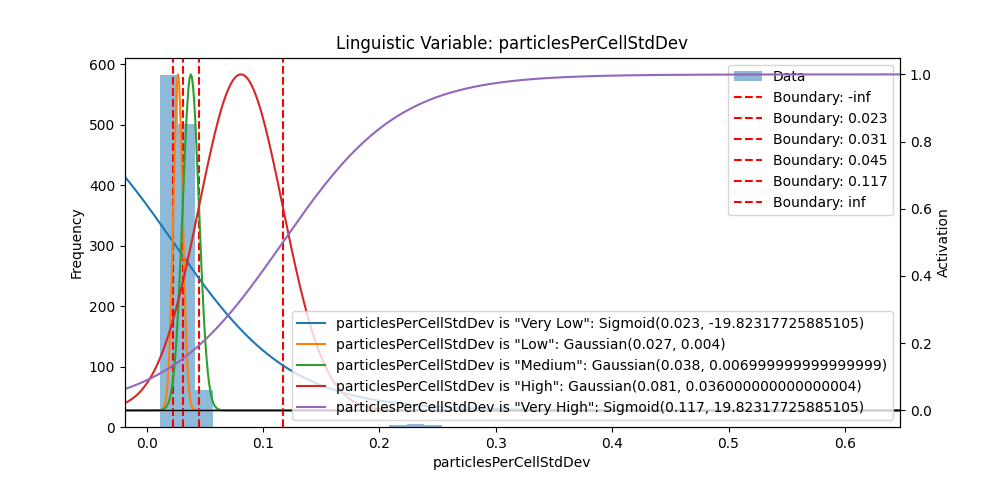

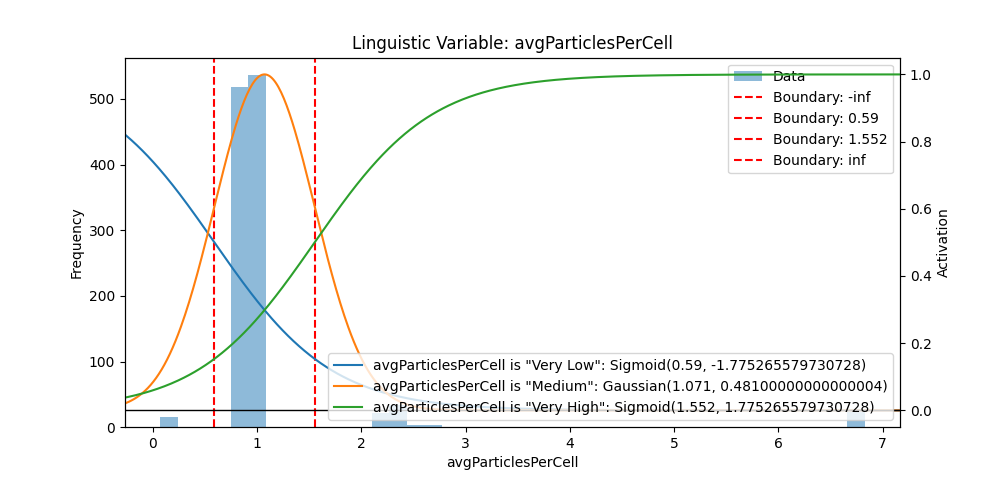

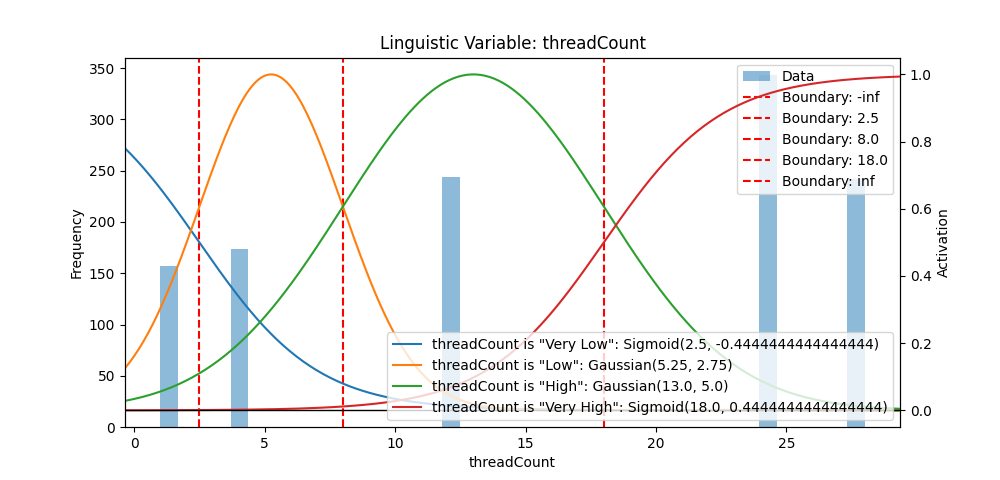

In [251]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


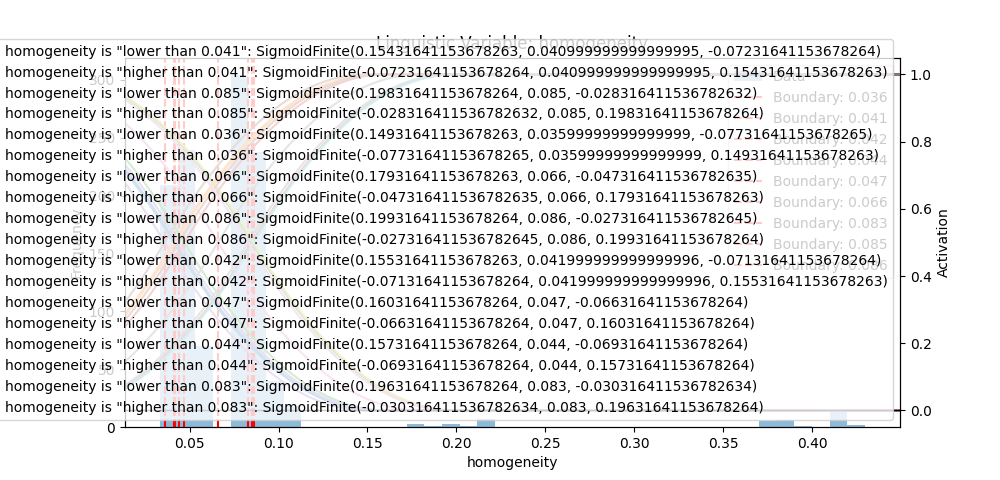

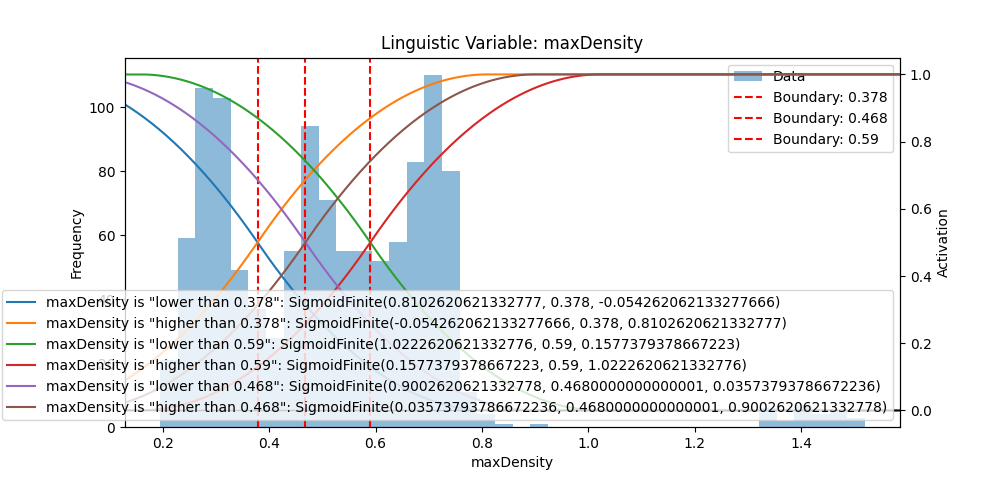

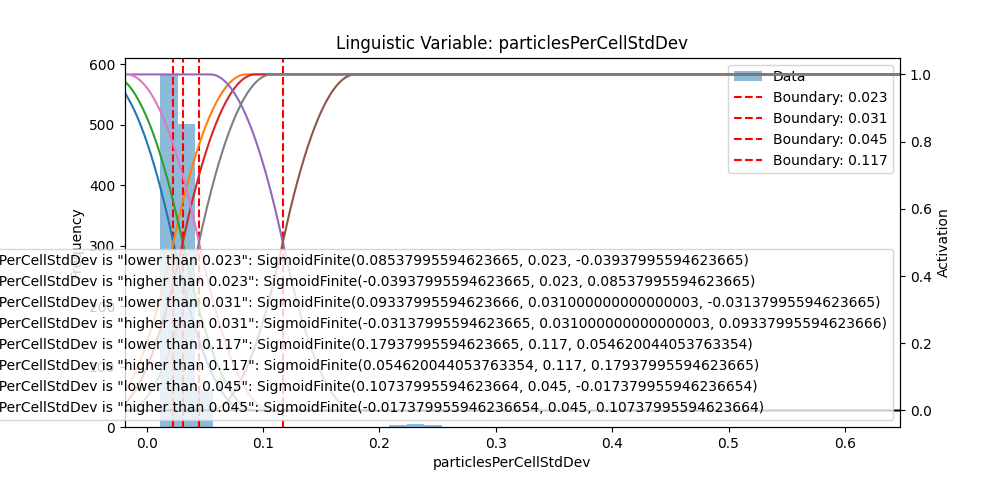

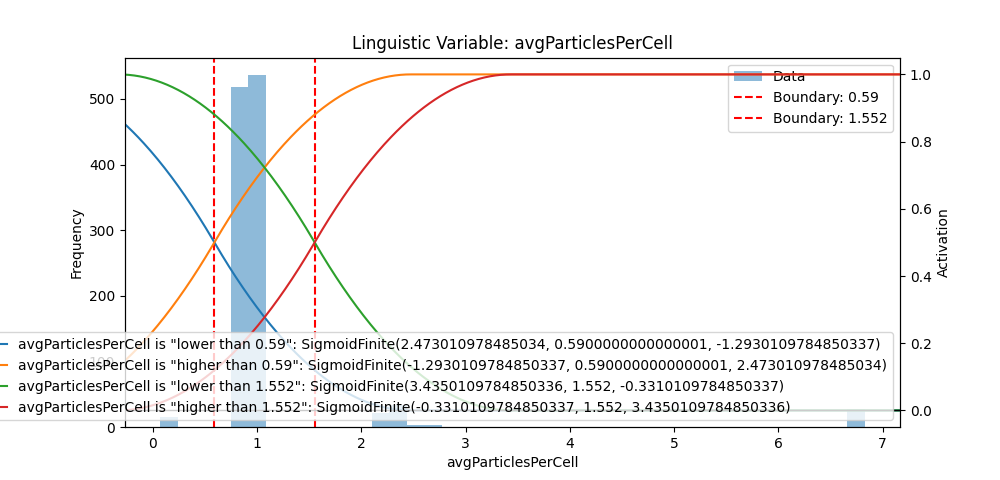

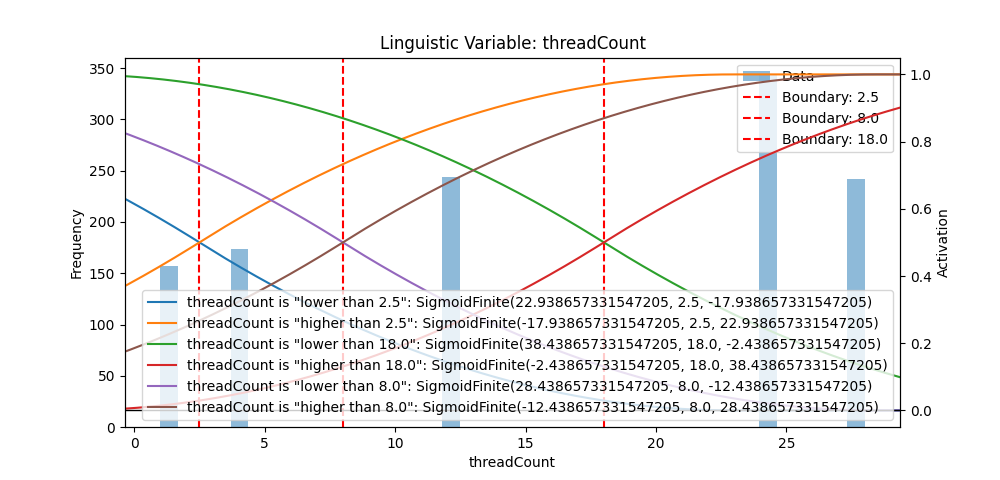

In [252]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/../demo/fuzzy-test/python/fuzzy_system.py:380: RuntimeWarning: invalid value encountered in scalar divide
  def function(x): return np.exp(-0.5 * ((x - mean) / sigma) ** 2)
/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/cluster-examples-pause/../rule_extraction.py:542: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  #


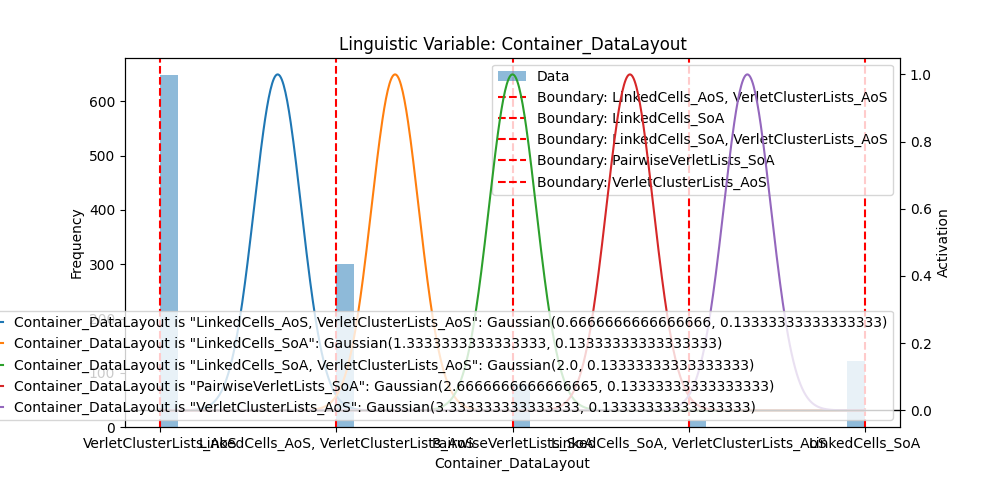

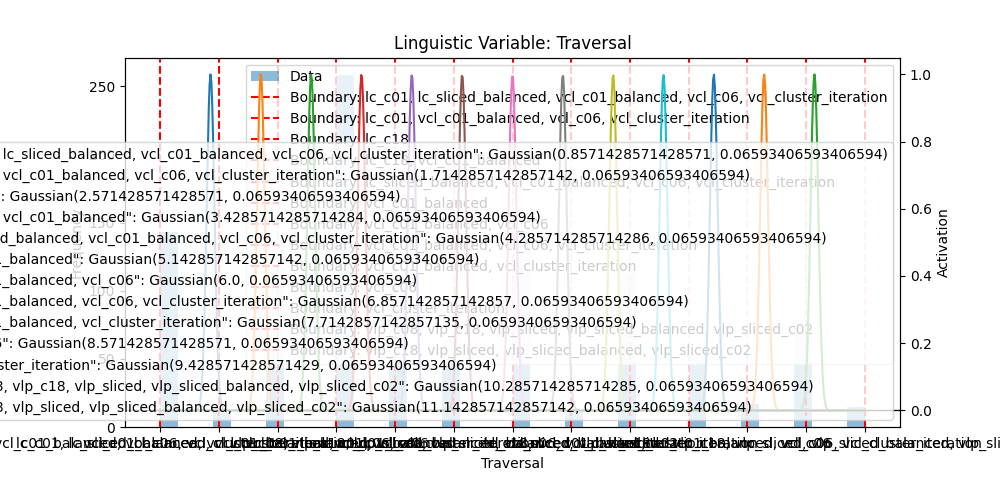

In [253]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [254]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "homogeneity" range: (-0.07980741153678264, 0.5428934115367826)
	"Extremely Low": Sigmoid(0.036, -2399.9999999999977)
	"Very Low": Gaussian(0.0385, 0.0025000000000000022)
	"Low": Gaussian(0.042499999999999996, 0.0014999999999999979)
	"Medium": Gaussian(0.0455, 0.0015000000000000013)
	"Medium 3": Gaussian(0.0565, 0.009500000000000001)
	"High": Gaussian(0.07450000000000001, 0.0085)
	"Very High": Gaussian(0.084, 0.0010000000000000009)
	"Extremely High": Sigmoid(0.085, 705.8823529411765)

FuzzyVariable: domain: "maxDensity" range: (-0.23721406213327767, 1.9521540621332778)
	"Very Low": Sigmoid(0.378, -9.057670186074738)
	"Low": Gaussian(0.42300000000000004, 0.04500000000000001)
	"High": Gaussian(0.529, 0.06099999999999997)
	"Very High": Sigmoid(0.59, 9.057670186074738)

FuzzyVariable: domain: "particlesPerCellStdDev" range: (-0.05067095594623665, 0.6794409559462367)
	"Very Low": Sigmoid(0.023, -19.82317725885105)
	"Low": Gaussian(0.027, 0.004)
	"Medium": Gaussian(0.0